# 023 10x10 Log - Continuação
O objetivo desse notebook é testar o modelo em ambiente 10x10 para registrar os resultados.

## Imports

In [1]:
from __future__ import absolute_import, division, print_function

import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import logging
logging.disable(logging.WARNING) 

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.metrics import tf_metrics
from tf_agents.utils import common

import sys
import gym

from resources import build_agent, TrainingSession, compute_logs
import pandas as pd
import gc

from resources import create_policy_eval_video
from resources import plot_all_metrics

## Parâmetros

In [2]:
combination = 0
gamma_option = 0
epsilon_option = 0
buffer_option = 0
lr_option = 0

buffer_options = [100_000, 50_000, 10_000, 1_000, 100]
fc_options = [(100,50), (100,50,50), (200,100), (200,)]

gamma_options = [0.99, 0.9, 0.75, 0.5]
eps_greedy_otions = [0.7, 0.6, 0.5]

lr_options = [1e-4, 1e-3, 1e-2]

In [3]:
# Historical Environments
# 1 - Observation: walls + distance, 3 rewards
# 2 - Observation: walls + r + theta, 4 rewards
# 3 - Observation: walls + r + theta + movement history, 4 rewards
hist_env = 3


# Hiperparameters
num_iterations = 10_000 

initial_collect_steps = 100
collect_steps_per_iteration = 1 
replay_buffer_max_length = buffer_options[buffer_option]  

batch_size = 64  
learning_rate = 1e-3  
log_interval = 100  

num_eval_episodes = 10  
eval_interval = 100  

# Agent fully connected layer params 
fc_layer_params = fc_options[3]
without_wall_training = True
early_stop = "finished2"

# Agent hyperparameters
gamma = gamma_options[gamma_option]
epsilon = eps_greedy_otions[epsilon_option]

# File's name
description = "023"

# Size of the maze
maze_size = 3

# Reward combination
#combination = 2 
run = 1

rewards = []
rewards.append({
    'destroyed': -10.,
    'stuck': - 6.,
    'reached': 10.,
    'standard': -1.
})
rewards.append({
    'destroyed': -10.,
    'stuck': -11.,
    'reached': 10.,
    'standard': -1.
})
rewards.append({
    'destroyed': -10.,
    'stuck': -15.,
    'reached': 10.,
    'standard': -1.
})
rewards.append({
    'destroyed': -500.,
    'stuck': 0.,
    'reached': 500.,
    'standard': -10.
})
rewards.append({
    'destroyed': 0.,
    'stuck': 0.,
    'reached': 100.,
    'standard': -10.
})
rewards.append({
    'destroyed': -50.,
    'stuck': 0.,
    'reached': 300.,
    'standard': -1.
})
rewards.append({
    'destroyed': -10.,
    'stuck': -11.,
    'reached': 50.,
    'standard': -1.
})



sys.path.append('/home/naski/Documents/dev/maze_drone_v02')
import gym_maze # Esta linha precisa estar após o PATH

# Importing custom environment
env_name = f'maze-v0-{hist_env}'
env = suite_gym.load(env_name)

# Testing
env.reset()

train_py_env = suite_gym.load(env_name)
# Converts environments, originally in pure Python, to tensors (using a wrapper)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)



# Inicializar o agente e carregar o checkpoint

In [4]:
# CREATING/RESETING THE AGENT
agent = build_agent(fc_layer_params, env, learning_rate, train_env, hist_env)
agent.initialize()

# GENERATE TRAINING SESSION
session = TrainingSession(description, maze_size, env_name, rewards[0], agent, collect_steps_per_iteration, 
                        1, eval_interval, replay_buffer_max_length, num_eval_episodes, hist_env)

# TRAINING
step_log, returns, finished, crashed, stucked, steped, _, replay_buffer, _ = session.train()

# CLEAR MEMORY
del(session)

Rewards: {'destroyed': -10.0, 'stuck': -6.0, 'reached': 10.0, 'standard': -1.0}
Size: 3
Mode: 1
Hist env: 3
learning_rate inside: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>


In [5]:
print(agent.train_step_counter)

checkpoint_dir = './checkpoint/phase-final-5x5'
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=agent.train_step_counter
)

print(agent.train_step_counter)


train_checkpointer.initialize_or_restore()
    
print(agent.train_step_counter)

agent._optimizer.learning_rate = learning_rate
print(agent._optimizer.learning_rate)

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=1>
<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=59600>
<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=59600>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>


### Check de sanidade

In [6]:
# ENVIRONMENT
evaluation_py_env = suite_gym.load(env_name)
evaluation_py_env.update_rewards(rewards[1]['destroyed'], rewards[1]['stuck'], rewards[1]['reached'], rewards[1]['standard'])
evaluation_py_env.set_mode(0)
evaluation_py_env.set_size(5)
evaluation_py_env.set_hist_env(hist_env)

# Converts environments, originally in pure Python, to tensors (using a wrapper)
evaluation_env = tf_py_environment.TFPyEnvironment(evaluation_py_env)


In [9]:
avg_return, finished_percentage, crashes_counter, stuck_counter, avg_steps = compute_logs(evaluation_env, agent.policy, rewards[1], 1000, False, hist_env)
print(avg_return, finished_percentage, crashes_counter, stuck_counter, avg_steps)

-9.933 0.739 5 36 17.657


#### Resultado antigo:

In [28]:
avg_return, finished_percentage, crashes_counter, stuck_counter, avg_steps = compute_logs(eval_env, agent.policy, rewards[combination_5], 1000, False, hist_env)
print(avg_return, finished_percentage, crashes_counter, stuck_counter, avg_steps)

-8.98 0.759 5 65 16.634


# 10x10

## Training Phase 7 - Ambiente 10x10 sem paredes

In [10]:
# Atualiza hiperparametros
combination_4 = 0

gamma = gamma_options[0]
epsilon = eps_greedy_otions[2]
replay_buffer_max_length = buffer_options[1]
    
agent._optimizer.learning_rate = lr_options[1]
agent._epsilon_greedy = epsilon
agent._gamma =  gamma

num_iterations = 10_000

maze_size = 10

# GENERATE TRAINING SESSION
session = TrainingSession(description, maze_size, env_name, rewards[combination_4], agent, collect_steps_per_iteration, 
                        num_iterations, eval_interval, replay_buffer_max_length, num_eval_episodes, hist_env)

# TRAINING
step_log, returns, finished, crashed, stucked, steped, log_loss, buffer_checkpoint, agent = session.train(
    without_wall_training=True, early_stop="finished")


# LOGGING
df_log_7 = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 
                         'Stuck Counter': stucked, 'Avg Steps/Episode': steped, 'Loss log': log_loss})

check_7 = agent.train_step_counter.numpy()

Rewards: {'destroyed': -10.0, 'stuck': -6.0, 'reached': 10.0, 'standard': -1.0}
Size: 10
Mode: 1
Hist env: 3
learning_rate inside: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>


### Generate the video

In [11]:
# Reset the environment.
time_step = evaluation_py_env.reset()
evaluation_py_env.set_mode(True)
evaluation_py_env.set_size(10)


# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, f"trained-agent(phase7)-{description}", evaluation_env, evaluation_py_env)

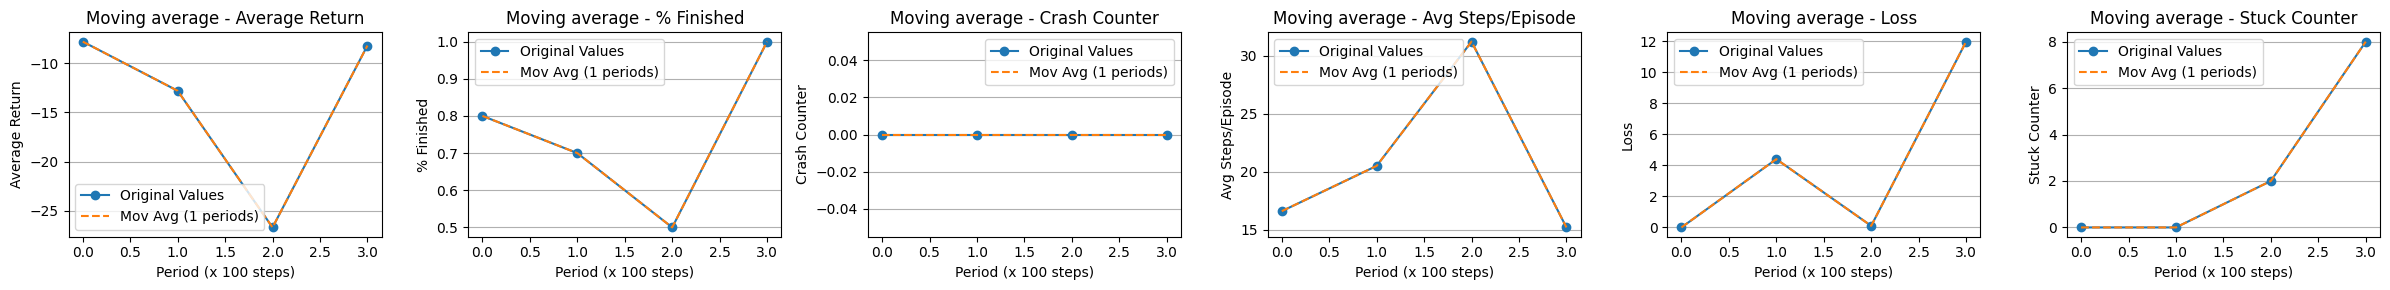

In [12]:
plot_all_metrics(df_log_7, period=-1, hist_env=hist_env)

## Training Phase 8 - Ambiente 10x10 com paredes

In [13]:
# Atualiza hiperparametros
    
combination_5 = 1

gamma = gamma_options[gamma_option]
epsilon = eps_greedy_otions[epsilon_option]
replay_buffer_max_length = buffer_options[buffer_option]
    
agent._optimizer.learning_rate = lr_options[1]
agent._epsilon_greedy = epsilon
agent._gamma =  gamma

# GENERATE TRAINING SESSION
session = TrainingSession(description, maze_size, env_name, rewards[combination_5], agent, collect_steps_per_iteration, 
                        num_iterations, eval_interval, replay_buffer_max_length, num_eval_episodes, hist_env)

# TRAINING
step_log, returns, finished, crashed, stucked, steped, log_loss, _, agent = session.train(without_wall_training=False, 
                                                                                          early_stop="finished")


# LOGGING
df_log_8 = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 
                         'Stuck Counter': stucked, 'Avg Steps/Episode': steped, 'Loss log': log_loss})


Rewards: {'destroyed': -10.0, 'stuck': -11.0, 'reached': 10.0, 'standard': -1.0}
Size: 10
Mode: 0
Hist env: 3
step = 60000
step = 61000
step = 62000
step = 63000
step = 64000
step = 65000
step = 66000
step = 67000
step = 68000
step = 69000
learning_rate inside: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>


### Generating the Video

In [16]:
# Reset the environment.
time_step = evaluation_py_env.reset()
evaluation_py_env.set_mode(False)
evaluation_py_env.set_size(10)


# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, f"trained-agent(phase8)-{description}", evaluation_env, evaluation_py_env, num_episodes=30)

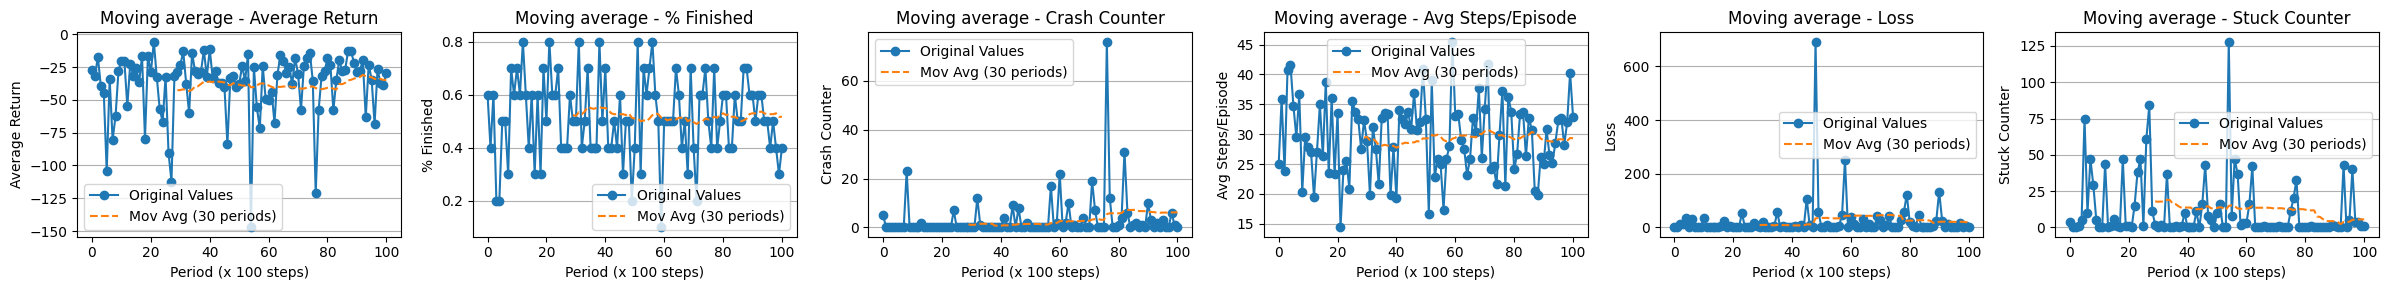

In [17]:
plot_all_metrics(df_log_8, period=-1, hist_env=hist_env)

## Training Phase 9 - Ambiente 10x10 (Fine Tuning)

In [18]:
# Atualiza hiperparametros
    
combination_5 = 1

gamma = gamma_options[gamma_option]
epsilon = eps_greedy_otions[epsilon_option]
replay_buffer_max_length = buffer_options[buffer_option]
    
agent._optimizer.learning_rate = lr_options[0]
agent._epsilon_greedy = 0.5
agent._gamma =  gamma
num_iterations = 40_000

# GENERATE TRAINING SESSION
session = TrainingSession(description, maze_size, env_name, rewards[combination_5], agent, collect_steps_per_iteration, 
                        num_iterations, eval_interval, replay_buffer_max_length, num_eval_episodes, hist_env)

# TRAINING
step_log, returns, finished, crashed, stucked, steped, log_loss, buffer_checkpoint, agent = session.train(
    without_wall_training=False, early_stop="finished")


# LOGGING
df_log_9 = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 
                         'Stuck Counter': stucked, 'Avg Steps/Episode': steped, 'Loss log': log_loss})



Rewards: {'destroyed': -10.0, 'stuck': -11.0, 'reached': 10.0, 'standard': -1.0}
Size: 10
Mode: 0
Hist env: 3
step = 70000
step = 71000
step = 72000
step = 73000
step = 74000
step = 75000
step = 76000
step = 77000
step = 78000
step = 79000
step = 80000
step = 81000
step = 82000
step = 83000
step = 84000
step = 85000
step = 86000
step = 87000
step = 88000
step = 89000
step = 90000
step = 91000
step = 92000
step = 93000
step = 94000
step = 95000
step = 96000
step = 97000
step = 98000
step = 99000
step = 100000
step = 101000
step = 102000
step = 103000
step = 104000
step = 105000
step = 106000
step = 107000
step = 108000
step = 109000
learning_rate inside: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>


In [19]:
# Reset the environment.
time_step = evaluation_py_env.reset()
evaluation_py_env.set_mode(False)
evaluation_py_env.set_size(10)


# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, f"trained-agent(phase9)-{description}", evaluation_env, 
                         evaluation_py_env, num_episodes=30)

In [23]:
# Reset the environment.
time_step = evaluation_py_env.reset()
evaluation_py_env.set_mode(False)
evaluation_py_env.set_size(10)


# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, f"trained-agent(phase9.1)-{description}", evaluation_env, 
                         evaluation_py_env, num_episodes=30)

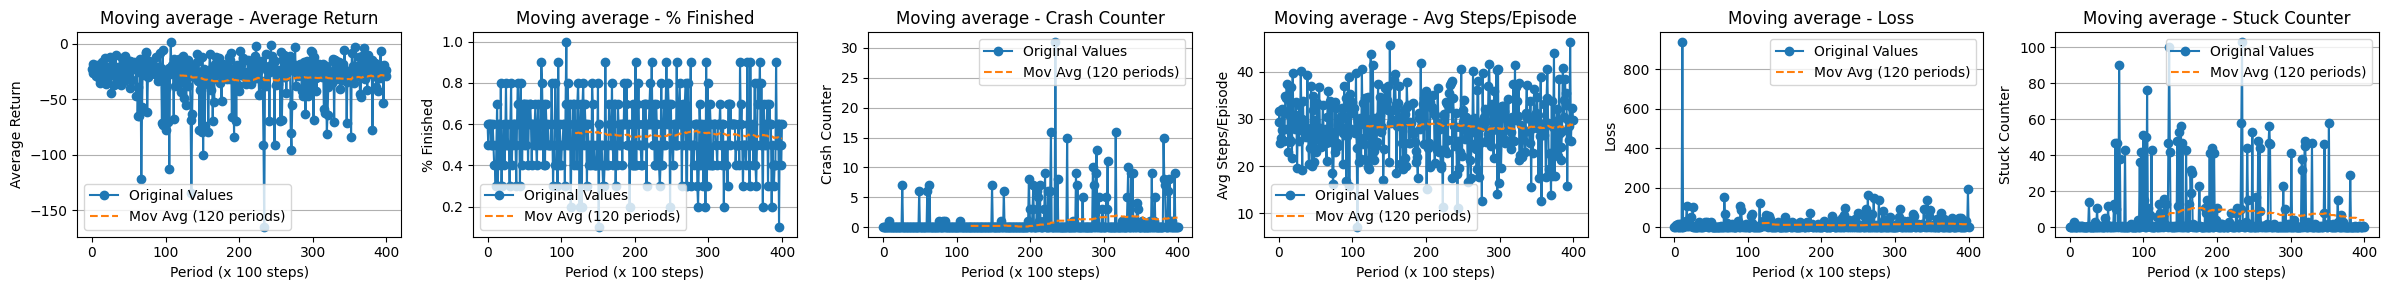

In [20]:
plot_all_metrics(df_log_9, period=-1, hist_env=hist_env)

In [21]:
# ENVIRONMENT
evaluation_py_env = suite_gym.load(env_name)
evaluation_py_env.update_rewards(rewards[1]['destroyed'], rewards[1]['stuck'], rewards[1]['reached'], 
                                 rewards[1]['standard'])
evaluation_py_env.set_mode(0)
evaluation_py_env.set_size(5)
evaluation_py_env.set_hist_env(hist_env)

# Converts environments, originally in pure Python, to tensors (using a wrapper)
evaluation_env = tf_py_environment.TFPyEnvironment(evaluation_py_env)


In [22]:
avg_return, finished_percentage, crashes_counter, stuck_counter, avg_steps = compute_logs(evaluation_env, 
                                                            agent.policy, rewards[1], 1000, False, hist_env)
print(avg_return, finished_percentage, crashes_counter, stuck_counter, avg_steps)

-19.862 0.665 143 549 20.4


In [24]:
checkpoint_dir = './checkpoint/phase-final-10x10'

train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=buffer_checkpoint,
    global_step=agent.train_step_counter
)

In [25]:
train_checkpointer.save(agent.train_step_counter)

# Final

In [26]:
df_log = pd.concat([df_log_7, df_log_8, df_log_9])
df_log.to_csv(f"logs/06-hist-env/{description}-10x10-combination_{combination_5}-epsilon_{epsilon_option}-gamma_{gamma_option}-buffer_{buffer_option}-lr_{lr_option}.csv", index=None, header=True)
